In [1]:
!which python

/Users/clarehuang/miniconda3/envs/falwa_env/bin/python


In [2]:
import falwa

In [3]:
import xarray as xr

In [4]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
from falwa.utilities import zonal_convergence

In [5]:
# Load MERRA2 dataset
uvt_data = xr.open_mfdataset("MERRA2/[UVT].1980.daily.nc")
dtdtlwr_data = xr.open_mfdataset("MERRA2/DTDTLWR.1980.daily.nc")

In [6]:
dtdtlwr_data

<xarray.Dataset>
Dimensions:  (time: 7, lon: 360, lat: 181, level: 37)
Coordinates:
  * time     (time) datetime64[ns] 1980-01-01T12:00:00 ... 1980-01-07T12:00:00
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
  * lat      (lat) float64 -90.0 -89.0 -88.0 -87.0 -86.0 ... 87.0 88.0 89.0 90.0
  * level    (level) float64 1e+03 975.0 950.0 925.0 900.0 ... 4.0 3.0 2.0 1.0
Data variables:
    DTDTLWR  (time, level, lat, lon) float32 dask.array<chunksize=(7, 37, 181, 360), meta=np.ndarray>
Attributes:
    CDI:          Climate Data Interface version 2.0.3 (https://mpimet.mpg.de...
    Conventions:  CF-1.6
    history:      Thu Jan 02 14:12:54 2025: cdo seldate,1980-01-01,1980-01-07...
    CDO:          Climate Data Operators version 2.0.3 (https://mpimet.mpg.de...

In [7]:
uvt_data['lon']

<xarray.DataArray 'lon' (lon: 360)>
array([  0.,   1.,   2., ..., 357., 358., 359.])
Coordinates:
  * lon      (lon) float64 0.0 1.0 2.0 3.0 4.0 ... 355.0 356.0 357.0 358.0 359.0
Attributes:
    standard_name:  longitude
    long_name:      longitude
    units:          degrees_east
    axis:           X

In [8]:
uvt_data['level']

<xarray.DataArray 'level' (level: 37)>
array([1000.,  975.,  950.,  925.,  900.,  875.,  850.,  825.,  800.,  775.,
        750.,  725.,  700.,  650.,  600.,  550.,  500.,  450.,  400.,  350.,
        300.,  250.,  200.,  150.,  100.,   70.,   50.,   40.,   30.,   20.,
         10.,    7.,    5.,    4.,    3.,    2.,    1.])
Coordinates:
  * level    (level) float64 1e+03 975.0 950.0 925.0 900.0 ... 4.0 3.0 2.0 1.0
Attributes:
    standard_name:  air_pressure
    long_name:      vertical level
    units:          hPa
    positive:       down
    axis:           Z
    vmin:           -1000000000000000.0
    vmax:           1000000000000000.0
    coordinate:     pressure

In [9]:
# Prepare coordinates

xlon = uvt_data['lon'].values
# latitude has to be in ascending order
ylat = uvt_data['lat'].values
# pressure level has to be in descending order (ascending height)
plev = uvt_data['level'].values

nlon = xlon.size
nlat = ylat.size
nlev = plev.size
print(f"nlon: {nlon}, nlat: {nlat}, nlev:{nlev}")


nlon: 360, nlat: 181, nlev:37


In [10]:
# Get once slice of data to test
tstep = 0
uu = uvt_data['U'].values[tstep, :, :, :]
vv = uvt_data['V'].values[tstep, :, :, :]
tt = uvt_data['T'].values[tstep, :, :, :]
dtdtlwr = dtdtlwr_data['DTDTLWR'].values[tstep, :, :, :]

In [11]:
from falwa.oopinterface import QGFieldNHN22

qgfield_nhn22 = QGFieldNHN22(xlon, ylat, plev, uu, vv, tt, northern_hemisphere_results_only=False, eq_boundary_index=5)
qgfield_nhn22.interpolate_fields(return_named_tuple=False)
qgfield_nhn22.compute_reference_states(return_named_tuple=False)

# New procedure: compute q_dot with the discretization scheme in qgfield_nhn22. 
# This is handled by the method compute_ncforce_from_heating_rate
ncforce = qgfield_nhn22.compute_ncforce_from_heating_rate(heating_rate=dtdtlwr)

# Existing func: Pass in the resultant ncforce term into "compute_lwa_and_barotropic_fluxes" would compute the barotropic component
qgfield_nhn22.compute_lwa_and_barotropic_fluxes(return_named_tuple=False, ncforce=ncforce)

# New func: Pass in the resultant ncforce term into "compute_lwa_and_barotropic_fluxes" would give the layerwise (3-D) fields
qgfield_nhn22.compute_layerwise_lwa_fluxes(ncforce=ncforce)

Do scipy interpolation
 nlon, nlat, kmax, jd
         360         181          49          91


Computed **3D-layerwise fluxes** in `QGField` can be accessed via `QGField._layerwise_flux_terms_storage`, e.g.,

```python
ua1_layerwise = np.swapaxes(qgfield_nhn22._layerwise_flux_terms_storage.ua1, 0, 2)
```
The shape of `ua1_3d` would be `(360, 181, 49)` (nlon, nlat, kmax). You can do `np.swapaxes(..., 0, 2)` to swap the axes back to (kmax, nlat, nlon) convention. Note that the fields stored in `QGField._layerwise_flux_terms_storage` are **not weighted by density**. 


In [12]:
ua1_3d = np.swapaxes(qgfield_nhn22._layerwise_flux_terms_storage.ua1, 0, 2)
ua2_3d = np.swapaxes(qgfield_nhn22._layerwise_flux_terms_storage.ua2, 0, 2)
ep1_3d = np.swapaxes(qgfield_nhn22._layerwise_flux_terms_storage.ep1, 0, 2)
ep2_3d = np.swapaxes(qgfield_nhn22._layerwise_flux_terms_storage.ep2, 0, 2)
ep3_3d = np.swapaxes(qgfield_nhn22._layerwise_flux_terms_storage.ep3, 0, 2)
stretch_term_3d = np.swapaxes(qgfield_nhn22._layerwise_flux_terms_storage.stretch_term, 0, 2)
lwa_3d = np.swapaxes(qgfield_nhn22._layerwise_flux_terms_storage.lwa, 0, 2)
ncforce_3d = np.swapaxes(qgfield_nhn22._layerwise_flux_terms_storage.ncforce, 0, 2)

## Compute zonal adv convergence and eddy momentum flux divergence

In [13]:
zonal_adv_flux_sum_3d = ua1_3d + ua2_3d + ep1_3d
convergence_zonal_advective_flux_3d = np.zeros((qgfield_nhn22.kmax, qgfield_nhn22.nlat, qgfield_nhn22.nlon))
divergence_eddy_momentum_flux_3d = np.zeros((qgfield_nhn22.kmax, qgfield_nhn22.nlat, qgfield_nhn22.nlon))

for k in range(qgfield_nhn22.kmax):
    convergence_zonal_advective_flux_3d[k, :, :] = zonal_convergence(
        field=zonal_adv_flux_sum_3d[k, :, :], 
        clat=qgfield_nhn22._clat,
        dlambda=qgfield_nhn22.dlambda,
        planet_radius=qgfield_nhn22.planet_radius)

divergence_eddy_momentum_flux_3d = (ep2_3d - ep3_3d) / (2 * qgfield_nhn22.planet_radius * qgfield_nhn22.dphi * qgfield_nhn22._clat)[np.newaxis, :, np.newaxis]

## Visualize `convergence_zonal_advective_flux_3d` and `ncforce` at pseudoheight 10km and 20km

In [14]:
def lat_lon_graph_plot(lat_lon_var, graph_title):
    plt.figure(figsize=(12,3))
    plt.contourf(xlon, ylat[-80:], lat_lon_var[-80:, :], cmap='jet')
    plt.axhline(y=0, c='w', lw=20)
    plt.ylabel('Latitude (deg)')
    plt.xlabel('Longitude (deg)')
    plt.colorbar()
    plt.title(graph_title)
    plt.show()

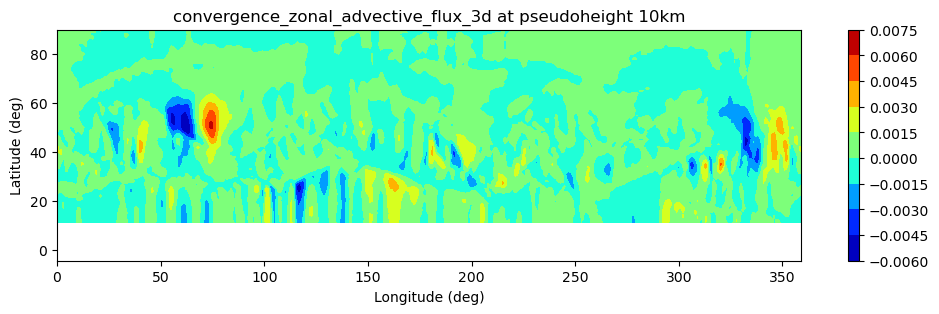

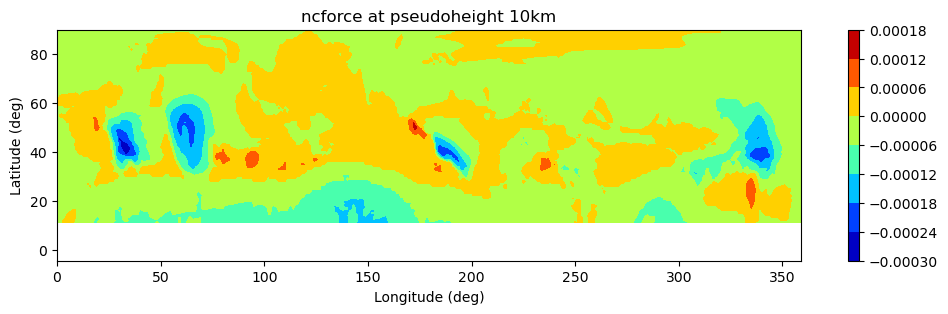

In [15]:
k=10
lat_lon_graph_plot(
    convergence_zonal_advective_flux_3d[k, :, :], 
    f"convergence_zonal_advective_flux_3d at pseudoheight {int(qgfield_nhn22.height[k]//1000)}km")
lat_lon_graph_plot(
    ncforce_3d[k, :, :], 
    f"ncforce at pseudoheight {int(qgfield_nhn22.height[k]//1000)}km")

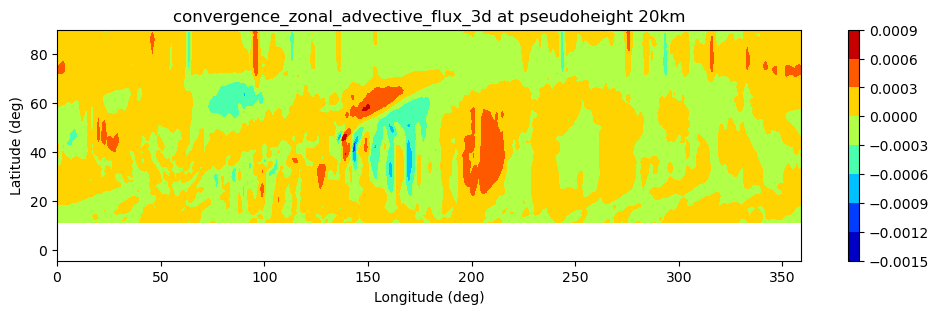

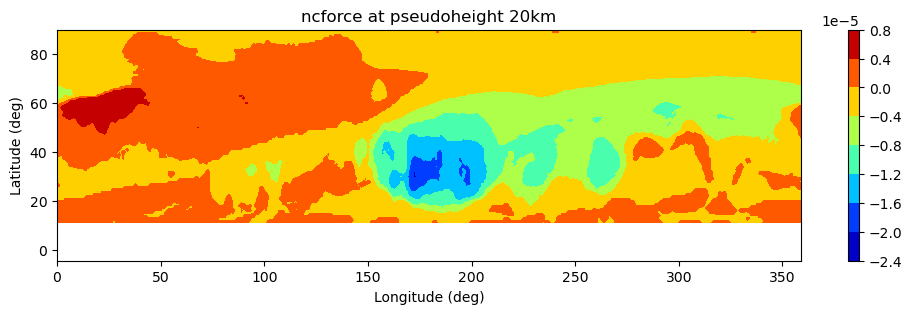

In [16]:
k=20
lat_lon_graph_plot(
    convergence_zonal_advective_flux_3d[k, :, :], 
    f"convergence_zonal_advective_flux_3d at pseudoheight {int(qgfield_nhn22.height[k]//1000)}km")
lat_lon_graph_plot(
    ncforce_3d[k, :, :], 
    f"ncforce at pseudoheight {int(qgfield_nhn22.height[k]//1000)}km")

## Visualize barotropic `convergence_zonal_advective_flux` and `ncforce`

In [17]:
convergence_zonal_advective_flux = qgfield_nhn22.convergence_zonal_advective_flux
ncforce_baro = qgfield_nhn22.ncforce_baro

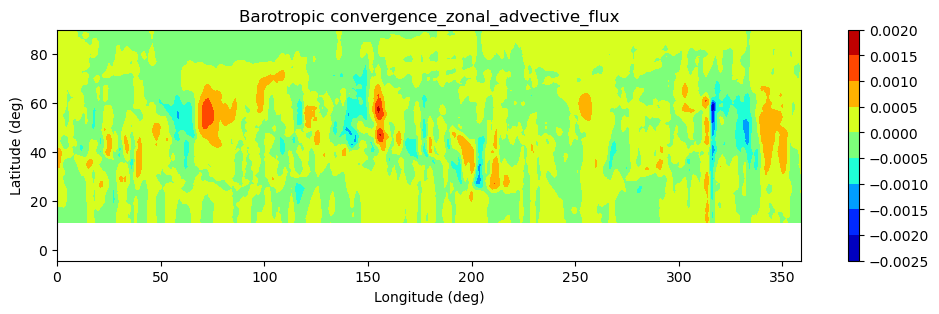

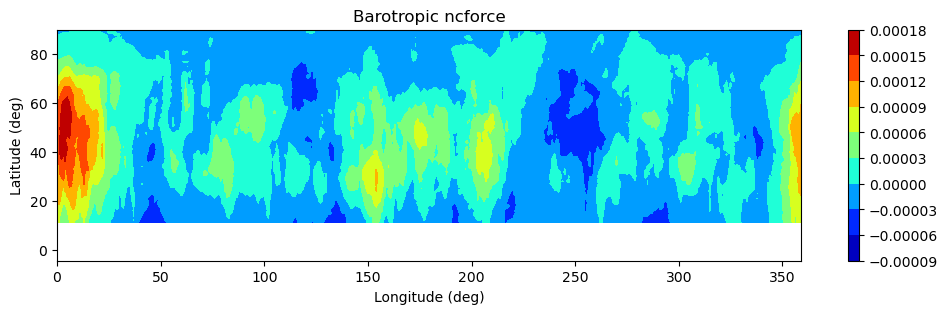

In [18]:
lat_lon_graph_plot(
    convergence_zonal_advective_flux, 
    f"Barotropic convergence_zonal_advective_flux")
lat_lon_graph_plot(
    ncforce_baro, 
    f"Barotropic ncforce")

## Compare vertically integrated term `ep4` and low-level meridional heat flux

To do density-weighted vertical average, call `QGField._vertical_average(field_3d, lowest_layer_index=1, height_axis=-1)`. Note that `field_3d` is assumed to have fortran indexing, i.e., (nlon, nlat, kmax).

In [22]:
stretch_term_3d.shape

(49, 181, 360)

In [29]:
ep4_from_vertical_avg = qgfield_nhn22._vertical_average(np.swapaxes(stretch_term_3d, 0, 2), lowest_layer_index=1, height_axis=-1)

In [30]:
ep4_from_vertical_avg.shape

(360, 181)

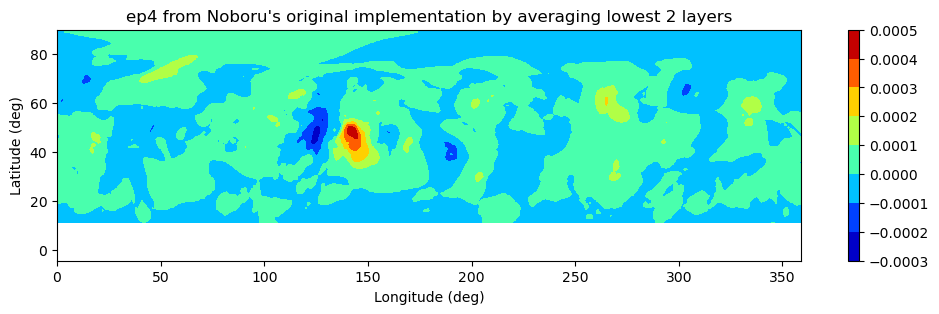

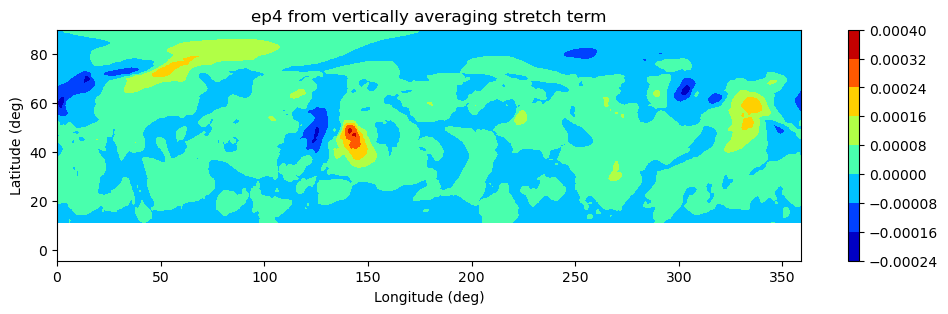

In [32]:
lat_lon_graph_plot(
    qgfield_nhn22.meridional_heat_flux, 
    f"ep4 from Noboru's original implementation by averaging lowest 2 layers")
lat_lon_graph_plot(
    ep4_from_vertical_avg.T, 
    f"ep4 from vertically averaging stretch term")